In [1]:
# Imports we will use
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb

# For matplotlib
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# Load data function
def create_dataloader(img_path, metadata_path, batch_size):
    '''
    Creates dataloader for training, reserving the last 10% images for validation/testing
    '''
    data = np.load(img_path).squeeze()
    length = len(data)
    data_train = torch.tensor(data[:int(.7*length)]) # 70% train
    data_test = torch.tensor(data[int(.7*length):int(.9*length)]) # 20% test
    data_val = torch.tensor(data[int(.9*length):]) # 10% validation

    metadata = pd.read_csv(metadata_path)
    labels = metadata['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()
    labels_train = torch.tensor(labels[:int(.7*length)])
    labels_test = torch.tensor(labels[int(.7*length):int(.9*length)])
    labels_val = torch.tensor(labels[int(.9*length):])

    data_train.cuda()
    data_test.cuda()
    data_val.cuda()
    labels_train.cuda()
    labels_test.cuda()
    labels_val.cuda()

    train_dataset = TensorDataset(data_train, labels_train)
    test_dataset = TensorDataset(data_test, labels_test)
    val_dataset = TensorDataset(data_val, labels_val)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader, data

In [3]:
# Load in data
head = Path.cwd().parents[3]
source_img_path = head / 'data/mb_source/mb_source.npy'
target_img_path = head / 'data/mb_target/mb_target.npy'
source_meta = head / 'data/mb_source/mb_source_metadata.csv'
target_meta = head / 'data/mb_target/mb_target_metadata.csv'
batch_size = 32
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)

In [5]:
# Define data visualization function
def visualize_data(data):
    '''
    visualizes 16 random images from dataset
    '''
    
    data_length = len(data)
    num_indices = 16
    
    # Generate 15 unique random indices using numpy
    random_indices = np.random.choice(data_length, size=num_indices, replace=False)

    #plot the examples for source
    fig1=plt.figure(figsize=(8,8))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.axis("off")

        img = data[random_indices[i]]
        example_image = make_lupton_rgb(img[0], img[1], img[2]) #change band by switching 0:1 to 1:2 or 2:3

        plt.imshow(example_image, aspect='auto', cmap='viridis')

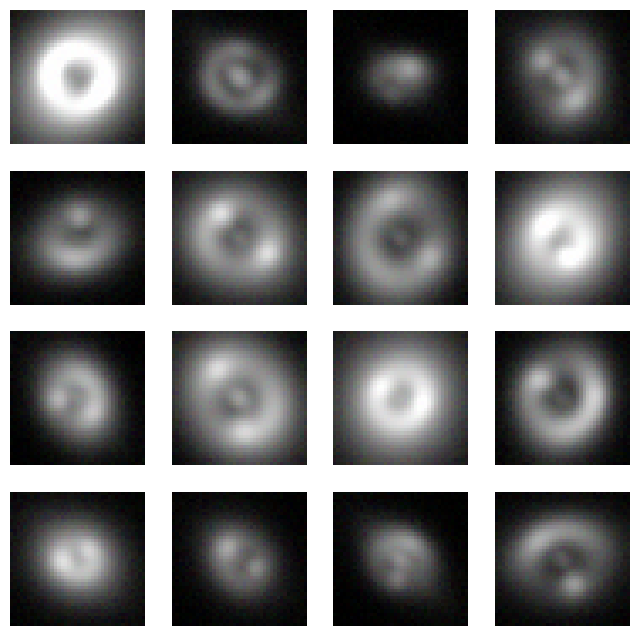

In [6]:
# Visualize source data
visualize_data(source_data)

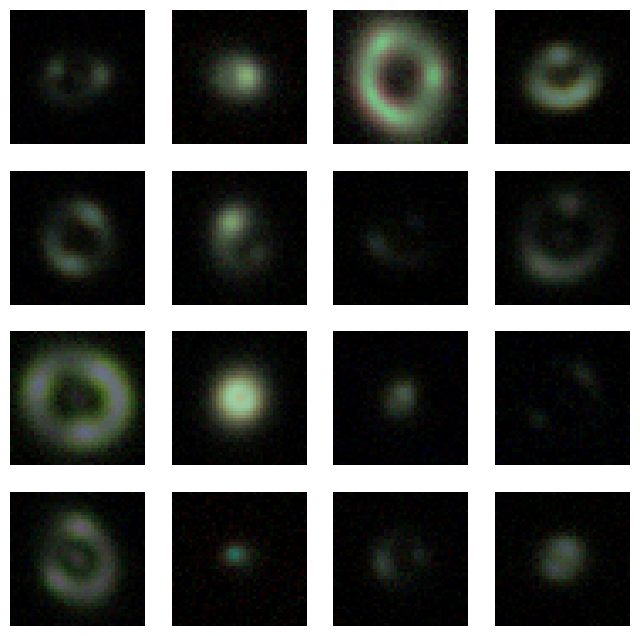

In [7]:
# Visualize target data
visualize_data(target_data)

In [24]:
# Define and initialize model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(8))
        self.feature.add_module('f_pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv2', nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu2', nn.ReLU(True))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(16))
        self.feature.add_module('f_pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature.add_module('f_conv3', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'))
        self.feature.add_module('f_relu3', nn.ReLU(True))
        self.feature.add_module('f_bn3', nn.BatchNorm2d(32))
        self.feature.add_module('f_pool3', nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Sequential()
        self.regressor.add_module('r_fc1', nn.Linear(in_features=32*5*5, out_features=128))
        self.regressor.add_module('r_relu1', nn.ReLU(True))
        #self.regressor.add_module('r_fc2', nn.Linear(in_features=128, out_features=64))
        #self.regressor.add_module('r_relu2', nn.ReLU(True))
        self.regressor.add_module('r_fc3', nn.Linear(in_features=128, out_features=1))

    def forward(self, x):
        x = x.view(-1, 3, 40, 40)

        features = self.feature(x)
        features = features.view(-1, 32*5*5)
        estimate = self.regressor(features)
        estimate = F.relu(estimate)
        estimate = estimate.view(-1)

        return estimate, features



In [100]:
# Code from https://github.com/ZongxianLee/MMD_Loss.Pytorch
# Comments by Shrihan Agarwal

class MMD_loss(nn.Module):
    """
    Calculate the MMD Loss using a Gaussian Kernel.
    MMD is the distance between the mean embeddings of the source/target dataset. 
    The distances are determined using a Gaussian kernel 
        k(x, y) ~ exp(-(x-y)^2 / (2 * sigma)).

    The bandwidth sigma is either input as fixed in `fix_sigma` or determined dynamically.
    One bandwidth is insufficient - small sigma leads to localization, and large leads to spread.
    Need to capture similarities at various scales.

    E.g. kernel_mul = 2, kernel_num = 5, fix_sigma = 1 creates:
    bandwidth_list = [1, 2, 4, 8, 16]

    Then uses pairwise kernel distances to compute MMD loss:
        Loss = Mean(source pairwise + target pairwise - source/target - target/source)
    
    """
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num # Number of kernels to use
        self.kernel_mul = kernel_mul # How much to multiply the kernel by to get a new kernel
        self.fix_sigma = None
        return
        
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])

        # Concatenate source and target catalogs along batch dimension
        # Source: (n, d), Target: (m, d), Total: (n + m, d)
        total = torch.cat([source, target], dim=0)

        # Replicate and calculate L2 distances between 
        # all samples, independent of source/target
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))

        # L2 distance is of shape (n + m, n + m)
        L2_distance = ((total0-total1)**2).sum(2)
        
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)

        # Create bandwidth list as described
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]

        # Calculate kernel based distance using list of bandwidths and aggregate
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]

        # Return the kernel matrix which is of shape (n + m, n + m), summing over bandwidths
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size] # source pairwise kernel dists
        YY = kernels[batch_size:, batch_size:] # target pairwise kernel dists
        XY = kernels[:batch_size, batch_size:] # between source and target samples
        YX = kernels[batch_size:, :batch_size] # between source and target samples
        loss = torch.mean(XX + YY - XY - YX)    # definition of MMD loss
        return loss

In [102]:
# Define training loop
def train_loop(source_dataloader, 
               target_dataloader, 
               model, 
               regressor_loss_fn,
               da_loss,
               optimizer,
               n_epoch,
               epoch):
    """
    Trains the Neural Network on Source/Target Domains with the following loss:
        Loss = Source Regression Loss + 1.4 * DA MMD Loss
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss).
	optimizer: Optimizer for the model parameters.
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    domain_error = 0
    domain_classifier_accuracy = 0
    estimator_error = 0
    score_list = np.array([])

    # Iteration length is shorter of the two datasets
    len_dataloader = min(len(source_dataloader), len(target_dataloader))
    data_source_iter = iter(source_dataloader)
    data_target_iter = iter(target_dataloader)

    # Iterate over the two datasets
    i = 0
    while i < len_dataloader:

        # Time-varying hyperparameter, p 0 -> infty, alpha 0 -> 1
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader # UNUSED
        alpha = 2. / (1. + np.exp(-10 * p)) - 1 # UNUSED

        # Source Training

        # Load a batch of source data, move to GPU
        data_source = next(data_source_iter)
        X, y = data_source
        X = X.float()
        X = X.cuda()
        y = y.cuda()

        # Zero model gradients and labels
        model.zero_grad()
        batch_size = len(y)

        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()
        domain_label = domain_label.cuda()

        # Apply data to model and get predictions, embeddings, apply gradients
        estimate_output, domain_output_source = model(X)

        # Calculate source regression loss based on predictions
        estimate_loss = regressor_loss_fn(estimate_output, y)

        # Target Training

        data_target = next(data_target_iter)
        X_target, _ = data_target
        X_target = X_target.float()
        X_target = X_target.cuda()

        batch_size = len(X_target)

        _, domain_output_target = model(X_target)

        # Calculate the DA Loss between source and target, MMD loss
        domain_loss = da_loss(domain_output_source, domain_output_target)

        # Hyperparameter of 1.4 set to weight domain loss vs source loss
        # Perhaps this is where alpha was initially used
        loss = estimate_loss + domain_loss*1.4

        # Backpropagation, update optimizer lr
        loss.backward()
        optimizer.step()

        # Update values
        
        # Domain loss is the DA loss or MMD loss between embedding outputs
        domain_error += domain_loss.item()

        # Estimator loss is the source data loss on regression
        estimator_error += estimate_loss.item()

        # Calculate the R2 score of the predictions vs. labels
        score = r2_score(y.cpu().detach().numpy(), estimate_output.cpu().detach().numpy())
        score_list = np.append(score_list, score)

        i += 1

    # Calculate average scores/errors of batches for this epoch
    score = np.mean(score_list)
    domain_error = domain_error / (len_dataloader)
    estimator_error /= len_dataloader

    return [domain_error, estimator_error, score]

In [104]:
# Define testing loop

def test_loop(source_dataloader, 
              target_dataloader, 
              model, 
              regressor_loss_fn, 
              da_loss, 
              n_epoch, 
              epoch):
    """
    Tests the model accuracy.
    
    source_dataloader: DataLoader for the source domain data.
	target_dataloader: DataLoader for the target domain data.
	model: The neural network model to be trained.
	regressor_loss_fn: Loss function for the regression task (e.g., MSELoss).
	da_loss: Loss function for domain adaptation (e.g., MMD loss). UNUSED
	n_epoch: Total number of epochs for training.
	epoch: Current epoch number.
    """

    
    # Evaluating without gradient computation in bg for validation
    with torch.no_grad():
        
        len_dataloader = min(len(source_dataloader), len(target_dataloader))
        data_source_iter = iter(source_dataloader)
        data_target_iter = iter(target_dataloader)

        
        domain_classifier_error = 0
        domain_classifier_accuracy = 0
        estimator_error = 0
        estimator_error_target = 0
        score_list = np.array([])
        score_list_target = np.array([])

        i = 0
        while i < len_dataloader:

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # Source Testing

            data_source = next(data_source_iter)
            X, y = data_source
            X = X.float()
            X = X.cuda()
            y = y.cuda()

            batch_size = len(y)

            estimate_output, domain_output = model(X)

            estimate_loss = regressor_loss_fn(estimate_output, y)

            # Target Testing

            data_target = next(data_target_iter)
            X_target, y_target = data_target
            X_target = X_target.float()
            X_target = X_target.cuda()
            y_target = y_target.cuda()

            batch_size = len(X_target)

            estimate_output_target, domain_output = model(X_target)

            estimate_loss_target = regressor_loss_fn(estimate_output_target, y_target)

            # Update values

            # Regression loss on validation testing
            estimator_error += estimate_loss.item()
            estimator_error_target += estimate_loss_target.item()

            # R2 Scores on validation testing
            score = r2_score(y.cpu(), estimate_output.cpu())
            score_list = np.append(score_list, score)
            score_target = r2_score(y_target.cpu(), estimate_output_target.cpu())
            score_list_target = np.append(score_list_target, score_target)

            i += 1

        score = np.mean(score_list)
        score_target = np.mean(score_list_target)
        estimator_error /= len_dataloader
        estimator_error_target /= len_dataloader
        
    classifier_error = 1
    return [classifier_error, estimator_error, estimator_error_target, score, score_target]

In [136]:
# Initialize dictionary for training stats
import time
model = NeuralNetwork().cuda()
# Hyper parameter presets
learning_rate = 6e-5
epochs = 30
# Define loss functions and optimizer
regressor_loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
da_loss = MMD_loss()

In [137]:
def print_epoch_scores(stats, epoch, t):
    """ Prints all relevant scores for each epoch. """
    train_stats = [i for i in stats.keys() if "train" in i]
    val_stats = [i for i in stats.keys() if "val" in i]
    fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')]) + ": "
    
    print("\nEpoch {0}: {1:.2f}s".format(epoch, t) + "\n-------------------------------")
    print(" Training Statistics:")
    for s in train_stats:
        print("\t" + fmt(s) + ": {:.4f}".format(stats[s][-1]))
    print(" Validation Statistics:")
    for s in val_stats:
        print("\t" + fmt(s) + ": {:.4f}".format(stats[s][-1]))

In [138]:
stats = {'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[]}

print("Beginning Training...")
# Train
for i in range(epochs):
        start_time = time.time()
        vals = train_loop(source_train_dataloader, target_train_dataloader, model,
                   regressor_loss_fn, da_loss, optimizer, epochs, i)

        vals_validate = test_loop(source_val_dataloader, target_val_dataloader,
                         model, regressor_loss_fn, da_loss, epochs, i)

        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_r2_score'].append(vals[2])
        stats['val_source_regression_loss'].append(vals_validate[1])
        stats['val_target_regression_loss'].append(vals_validate[2])
        stats['val_source_r2_score'].append(vals_validate[3])
        stats['val_target_r2_score'].append(vals_validate[4])

        print_epoch_scores(stats, i, time.time() - start_time)
        
        # to_print = (
        #     f'Train Estimator Error = {vals[1]}\n'
        #     f'Train Estimator R2 Score = {vals[2]:.4f}\n'
        #     f'Train Domain Classifier Error = {vals[0]}\n'
        #     f'Validation Source Estimator Error = {vals_validate[1]}\n'
        #     f'Validation Source R2 Score = {vals_validate[3]:.4f}\n'
        #     f'Validation Target Estimator Error = {vals_validate[2]}\n'
        #     f'Validation Target R2 Score = {vals_validate[4]:.4f}\n'
        #     f'Validation Domain Classifier Error = {vals_validate[0]}\n'
        # )

        # print(to_print)

Beginning Training...

Epoch 0: 12.36s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2037
	Train Regression Loss: : 0.2505
	Train R2 Score: : 0.4932
 Validation Statistics:
	Val Source Regression Loss: : 0.0562
	Val Target Regression Loss: : 0.3287
	Val Source R2 Score: : 0.8845
	Val Target R2 Score: : 0.3357

Epoch 1: 10.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1194
	Train Regression Loss: : 0.0476
	Train R2 Score: : 0.9035
 Validation Statistics:
	Val Source Regression Loss: : 0.0347
	Val Target Regression Loss: : 0.1922
	Val Source R2 Score: : 0.9286
	Val Target R2 Score: : 0.6082

Epoch 2: 10.49s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.1074
	Train Regression Loss: : 0.0339
	Train R2 Score: : 0.9312
 Validation Statistics:
	Val Source Regression Loss: : 0.0283
	Val Target Regression Loss: : 0.1532
	Val Source R2 Score: : 0.9408
	Val Target R2 Score: : 0.6876

Epoch 3: 10.62s
----------

In [139]:
'train_DA_loss':[],
             'train_regression_loss':[],
             'train_r2_score':[],
             'val_source_regression_loss':[],
             'val_target_regression_loss':[],
             'val_source_r2_score':[],
             'val_target_r2_score':[]}

SyntaxError: illegal target for annotation (2919055091.py, line 1)

In [ ]:
# Classifier
eps = np.arange(epochs)
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'])

In [ ]:
# Estimator
plt.title("Estimator Error")
plt.plot(eps, stats['train_estimator_error'])
plt.plot(eps, stats['val_estimator_error'])
plt.plot(eps, stats['val_estimator_error_target'])

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_score'])
plt.plot(eps, stats['val_score'])
plt.plot(eps, stats['val_score_target'])

Source R2 Score is 0.9778


Text(0.5, 1.0, 'MMD | Source | R2: 0.978')

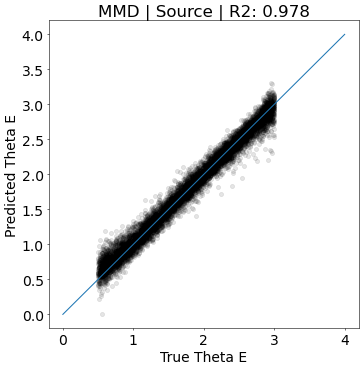

In [43]:
# Test Source
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(score))

Target R2 Score is 0.9597


Text(0.5, 1.0, 'MMD | Target | R2: 0.960')

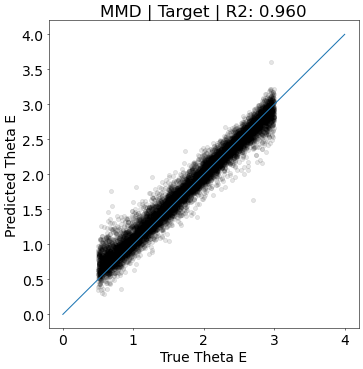

In [44]:
# Test target
preds = np.array([])
true = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds = np.append(preds, pred.cpu())
        true = np.append(true, y.cpu())
        score = r2_score(y.cpu(), pred.cpu())
        score_list = np.append(score_list, score)

score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

plt.figure(figsize=(8,8),dpi=50)
plt.scatter(true, preds,  color='black', alpha = 0.1)
line = np.linspace(0, 4, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(score))